# Tutorial 1. Troubleshooting WESTPA simulation errors
Author: Jeremy Leung, Darian Yang, Mac Kevin Braza<br>
Email:&nbsp;&nbsp; jml230@pitt.edu, dty7@pitt.edu, mbraza@ucsd.edu

## Introduction

This document is a companion jupyter notebook for first tutorial in the 2024 WESTPA workshop. It involves running a SynD-based simulation of NTL9 protein folding using WESTPA. Upon completion of this tutorial, a user should be able to: set up and initialize their own WESTPA simulation system, troubleshoot common errors associated with WESTPA setup and simulation, analyze output data and track probability distributions of completed WE simulations, and update the progress coordinate or binning scheme on-the-fly during WE simulations.

### Simulation System: NTL9 Protein Folding using SynD



#### Synthetic Dynamics (SynD)

This notebook involves running a NTL9 folding simulation propagated using Synthetic Dynamics (SynD). In SynD, dynamics are propagated using kinetic Monte Carlo. That is, instead of propagating in the real xyz space (which is slow and requires calculating forces and positions for each atom frequently), we propagate by jumping around a transition matrix (generated from a Markov State Model) to different states. In a transition matrix, each element represents a row-to-column transition probability between states. By using a random number generator, we could generate a sequence of states based on the probabilities associated to the current occupied state. After generating a sequence of states, we can map each state to a representative full atom structure, which will string together to form a (coarse) full atom trajectory. The mapping is made before hand based on data used to make the transition matrix. Because the mapping is pre-determined and the number of states finite, we do not generate new data. However, we can generate MD-like trajectories useful for method development where we want dynamics propagation to be short and quick.


For more information, see this preprint and the GitHub Repository:
* https://arxiv.org/abs/2204.04343
* https://github.com/jdrusso/synd

## 1. Learning Objectives


* Walk through the process of debugging a WESTPA simulation
* Showcase of common errors and other help resources
* Change Progress Coordinate mid-simulation
* How to use WEDAP to track progress/debug simulation

### Notebook Structure

Each section of this notebook is structured as follows:
1. try to run the WE simulation
2. you have encountered an error
3. Try to fix this
4. Stuck? Check out the hints section.
5. Still stuck? Check out the solutions section.
6. "Checkpoints" are available as checkpoints to jump to certain sections.
   * Remove all current changes via ``git stash``
   * Run ``git apply <file name in patches/>``

## 2. System Requirements

- synd, westpa, wedap, scikit-learn, MDAnalysis, and MDTraj are necessary to run this simulation.
    - Note that MDTraj is a dependency of WESTPA 2.0.
- See the "3. Setting Up this Notebook" section for instructions.

## 3. Setting up this Notebook

Run this section to setup this notebook.

### Default Setup

If you're here during the workshop, we assumed you already have an environment set up. Just make sure your kernel says ``westpa-workshop2024`` (top left corner, next to ⃝).

If you're using this notebook on your own, you can create a working environment with the ``env.yaml`` file via ``conda env create -f env.yaml``. If you prefer pip, you can also install all needed packages with the command ``python -m pip install -r ../ntl9_sample_files/requirements.txt``.

### CONDA on Google COLAB

In [1]:
# RUN THIS ONCE. After kernel restart, proceed to the next cell.
!pip install -q condacolab
import condacolab
condacolab.install()

## KERNEL WILL RESTART

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...


In [1]:
# After kernel restart, start from here:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [2]:
from google.colab import output
output.enable_custom_widget_manager()

In [3]:
!git clone --quiet https://github.com/westpa/westpa-workshop2024-tutorials
%cd westpa-workshop2024-tutorials/tutorial1-troubleshooting
!mamba env update -n base -f env.yaml --quiet
%cd /content

/content/westpa-workshop2024-tutorials/tutorial1-troubleshooting

  Pinned packages:

  - python 3.10.*
  - python_abi 3.10.* *cp310*
  - cuda-version 12.*


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Installing pip dependencies: ...working... done
/content


In [4]:
%cd westpa-workshop2024-tutorials/tutorial1-troubleshooting
!ls

/content/westpa-workshop2024-tutorials/tutorial1-troubleshooting
1.clean.sh	 env.yaml	    README.md  trunc_aggr_time.py  westpa_scripts
completed_files  init.sh	    run.sh     tutorial1.ipynb
env.sh		 ntl9_folding_synd  sbstates   west.cfg


## 4. Initialization
This section is on common errors during Initialization.

1. Run ``bash init.sh``.
2. You may or may not have encountered an error. Can you figure out what's wrong?

In [ ]:
!bash init.sh

### Hints (click arrow to open)


The error is either silent or looks like this:

```
-- ERROR    [westpa.core.propagators.executable] -- could not read pcoord for BasisState None from '/tmp/tmpmq5sdswm': ValueError('progress coordinate data has incorrect shape (0,) [expected (1,)] Check pcoord.err or seg_logs for more information.')
/Users/user/app/westpa-project/src/westpa/core/propagators/executable.py:43: UserWarning: loadtxt: input contained no data: "/tmp/tmpjqkekz7g"
  pcoord = np.loadtxt(pcoord_return_filename, dtype=system.pcoord_dtype)
```

* This error is related to the bstate pcoord.
  * If you installed ``h5py`` via ``conda`` (or source), you can quickly check by running ``h5ls -d west.h5/ibstates/0/bstate_pcoord``.
  * Otherwise, you can run ``import h5py; print(h5py.File('west.h5')['ibstates/0/bstate_pcoord'][:])``.
* Allow WESTPA to output the ``get_pcoord.sh`` errors into an accessible file.
* All BasisState calculations run in parallel by default. Have you tried using `--n-workers=1` or `--work-manager=serial` to limit the parallelization?
* This issue extends to the HDF5 Framework but can be fixed the same way.


In [ ]:
# Run the following.
import h5py
with h5py.File('west.h5') as h5file:
  print(h5file['ibstates/0/bstate_pcoord'][:])

### Solution  (click arrow to open)

#### Explanations

First, you may notice that only some of the basis state calculations failed. You may also notice that a lot of the basis states progress coordinate have the same value when looking at the ``west.h5['ibstates/0/bstate_pcoord']`` dataset. This duplicate pcoord error is due to a race condition between the different basis state calculations.  There should be some FileNotFound related errors when looking at the get_pcoord output.

- To better visualize (and debug) the error, we will modify the following lines (L105) in ``west.cfg``, so the output from ``get_pcoord.sh`` will export into ``$WEST_SIM_ROOT/get_pcoord.log``.

    ```
  west:
    executable:
      get_pcoord:
        executable: $WEST_SIM_ROOT/westpa_scripts/get_pcoord.sh
        stdout:     $WEST_SIM_ROOT/get_pcoord.log  # WE CHANGED THIS LINE
        stderr:     stdout
  ```


  - Running parallel tasks may lead to something called a [race condition](https://en.wikipedia.org/wiki/Race_condition), where the final output/result will depend on which of the parallel tasks (also called threads or processes) finishes first. You might observe a mix of errors and successful outputs when repeatedly running the same program. This is typically **NOT** desireable. One way to circumvent this is by isolating the tasks so they are completely independent from each other.


  - In the ``get_pcoord.sh`` file, notice that we are writing the progress coordinate into ``pcoord.dat``. When we are executing the ``get_pcoord.sh`` file many times simultaneously(for the many BasisStates), one process may overwrite the ``pcoord.dat`` file written by the other process.

  - We will prevent this by writing our pcoord results into a temporary file generated with ``mktemp``. ``mktemp`` is an [UNIX command](https://www.gnu.org/software/autogen/mktemp.html) used to create empty files (or directories) with a unique name (typically called ``tmp.XXXXXXXX``). ``mktemp`` will return the generated file path when called.
    - It is good practice to delete your temp file after use, so you're not clogging up the ``/tmp`` folder (which is most often cleaned by the OS during reboot).
    - You can also use ``mktemp -u`` to return a unique name (but not the file). Do note that the file might be briefly created and deleted in the process when you use ``-u``.

#### How to fix it

* We will modify ``get_pcoord.sh`` as below. Note that we replaced most of the output files with a temp file (or unique file name).

  ```
  #!/bin/bash
  cd $WEST_SIM_ROOT/ntl9_folding_synd

  # >>>>> Make temporary files <<<<<
  PCOORD=$(mktemp)
TEMP_NAME=$(basename $(mktemp -u))

  # Grab Cluster ID
  CLUSTERID=$(basename $WEST_STRUCT_DATA_REF)

  # >>>>> Calculate Pcoord <<<<<
  # This takes in a cluster number as argument and returns the pcoord.
  python map_pcoord.py $CLUSTERID > $PCOORD

  # >>>>> Backmap for a coordinate file <<<<<
  # This takes in cluster number and file name as arguments
  # and outputs a {file name}.nc coordinate file.
  python map_coord.py $CLUSTERID $TEMP_NAME

  # >>>>> Return Pcoord <<<<<
  cat $PCOORD > $WEST_PCOORD_RETURN
  rm $PCOORD

  # >>>>> For HDF5 Framework <<<<<
  cp ntl9.pdb $WEST_TRAJECTORY_RETURN
cp $TEMP_NAME.nc $WEST_TRAJECTORY_RETURN/seg.nc
rm $TEMP_NAME.nc

  # cp ntl9.pdb $WEST_RESTART_RETURN
cat $CLUSTERID > $WEST_RESTART_RETURN/parent.txt
```

## 5. Running Simulation

This section is on common errors during a WE simulation.

This step involves debugging two different errors.
1. Run `bash run.sh`
2. You should hit an error regarding the BinMapper.
3. Once you fix the previous error, you should get another error regarding the segment weights.

In [ ]:
!bash run.sh

### Checkpoints

If you skpped Section 4, you may start by running ``git stash`` and ``git apply patches/solution_1.patch`` to reach this check point.

If you want to skip debugging the first error in this section, you may start by running ``git stash`` and ``git apply patches/solution_2.patch`` to reach the next check point.

### Hints (click arrow to open)

#### First Error

The first error should look like this:

```
Wed May 15 14:07:27 2024
Iteration 1 (50 requested)
Beginning iteration 1
4 segments remain in iteration 1 (4 total)
1 of 10 (10.000000%) active bins are populated
per-bin minimum non-zero probability:       1   
per-bin maximum probability:                1   
per-bin probability dynamic range (kT):     0   
per-segment minimum non-zero probability:   0.227273
per-segment maximum non-zero probability:   0.318182
per-segment probability dynamic range (kT): 0.336472
norm = 1, error in norm = -3.33067e-16 (-1.5*epsilon)
Waiting for segments to complete...
exception caught; shutting down
-- ERROR    [w_run] -- error message: coordinate value -12.967300415039062 is out of bin space in dimension 0
-- ERROR    [w_run] -- Traceback (most recent call last):
  File "/Users/user/app/westpa-project/src/westpa/cli/core/w_run.py", line 61, in run_simulation
    sim_manager.run()
  File "/Users/user/app/westpa-project/src/westpa/core/sim_manager.py", line 762, in run
    self.propagate()
  File "/Users/user/app/westpa-project/src/westpa/core/sim_manager.py", line 613, in propagate
    self.we_driver.assign(incoming)
  File "/Users/user/app/westpa-project/src/westpa/core/we_driver.py", line 344, in assign
    initial_assignments = self.bin_mapper.assign(all_pcoords[0, :, :])
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/user/app/westpa-project/src/westpa/core/binning/assign.py", line 174, in assign
    rectilinear_assign(coords, mask, output, self.boundaries, self._boundlens)
  File "src/westpa/core/binning/_assign.pyx", line 28, in westpa.core.binning._assign.rectilinear_assign
  File "src/westpa/core/binning/_assign.pyx", line 81, in westpa.core.binning._assign.rectilinear_assign
ValueError: coordinate value -12.967300415039062 is out of bin space in dimension 0
```
- Notice we have a negative pcoord value (but this is an RMSD value, which should be >= 0). I wonder why?
- Let's take at one of the many segment log files (in ``traj_segs `` and ``seg_logs``) and our 'runseg' file (``westpa_scripts/runseg.sh``).

#### Second Error

The second error could look two different ways:

```
Wed May 15 14:16:01 2024
Iteration 1 (50 requested)
Beginning iteration 1
4 segments remain in iteration 1 (4 total)
1 of 10 (10.000000%) active bins are populated
per-bin minimum non-zero probability:       1
per-bin maximum probability:                1
per-bin probability dynamic range (kT):     0
per-segment minimum non-zero probability:   0.227273
per-segment maximum non-zero probability:   0.318182
per-segment probability dynamic range (kT): 0.336472
norm = 1, error in norm = -3.33067e-16 (-1.5*epsilon)
Waiting for segments to complete...
Recycled 0.545455 probability (2 walkers) from target state 'folded'
Iteration completed successfully
Iteration wallclock: 0:00:00.786248, cputime: 0:00:02.468474

Wed May 15 14:16:02 2024
Iteration 2 (50 requested)
Beginning iteration 2
4 segments remain in iteration 2 (4 total)
exception caught; shutting down
-- ERROR    [w_run] -- Traceback (most recent call last):
  File "/Users/user/app/westpa-project/src/westpa/cli/core/w_run.py", line 61, in run_simulation
    sim_manager.run()
  File "/Users/user/app/westpa-project/src/westpa/core/sim_manager.py", line 758, in run
    self.prepare_iteration()
  File "/Users/user/app/westpa-project/src/westpa/core/sim_manager.py", line 495, in prepare_iteration
    self.report_bin_statistics(initial_binning, [], save_summary=True)
  File "/Users/user/app/westpa-project/src/westpa/core/sim_manager.py", line 191, in report_bin_statistics
    assert abs(1 - norm) < EPS * (len(segments) + n_active_bins)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError
```

- Looks like we completed iteration 1, with folding two events (which is a little early). This is odd.
- The `AssertionError` looks to be related to the weights, since it's related to something like (1-norm)

OR like this:

```
Updating system with the options from the configuration file
Maximum wallclock time: 2 days, 0:00:00

Sun Jun 16 22:54:00 2024
Iteration 1 (50 requested)
Beginning iteration 1
4 segments remain in iteration 1 (4 total)
1 of 10 (10.000000%) active bins are populated
per-bin minimum non-zero probability:       1
per-bin maximum probability:                1
per-bin probability dynamic range (kT):     0
per-segment minimum non-zero probability:   0.227273
per-segment maximum non-zero probability:   0.318182
per-segment probability dynamic range (kT): 0.336472
norm = 1, error in norm = -3.33067e-16 (-1.5*epsilon)
Waiting for segments to complete...
Recycled 1 probability (4 walkers) from target state 'folded'
exception caught; shutting down
-- ERROR    [w_run] -- error message: All chunk dimensions must be positive (all chunk dimensions must be positive)
-- ERROR    [w_run] -- Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/westpa/cli/core/w_run.py", line 61, in run_simulation
    sim_manager.run()
  File "/usr/local/lib/python3.10/site-packages/westpa/core/sim_manager.py", line 776, in run
    self.prepare_new_iteration()
  File "/usr/local/lib/python3.10/site-packages/westpa/core/sim_manager.py", line 731, in prepare_new_iteration
    self.data_manager.prepare_iteration(self.n_iter + 1, list(self.we_driver.next_iter_segments))
  File "/usr/local/lib/python3.10/site-packages/westpa/core/data_manager.py", line 853, in prepare_iteration
    pcoord_ds = create_dataset_from_dsopts(iter_group, pcoord_opts, shape, pcoord_dtype)
  File "/usr/local/lib/python3.10/site-packages/westpa/core/data_manager.py", line 1647, in create_dataset_from_dsopts
    dset = containing_group.require_dataset(h5_dsname, **opts)
  File "/usr/local/lib/python3.10/site-packages/h5py/_hl/group.py", line 275, in require_dataset
    return self.create_dataset(name, *(shape, dtype), **kwds)
  File "/usr/local/lib/python3.10/site-packages/h5py/_hl/group.py", line 183, in create_dataset
    dsid = dataset.make_new_dset(group, shape, dtype, data, name, **kwds)
  File "/usr/local/lib/python3.10/site-packages/h5py/_hl/dataset.py", line 104, in make_new_dset
    dcpl = filters.fill_dcpl(
  File "/usr/local/lib/python3.10/site-packages/h5py/_hl/filters.py", line 261, in fill_dcpl
    plist.set_chunk(chunks)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5p.pyx", line 472, in h5py.h5p.PropDCID.set_chunk
ValueError: All chunk dimensions must be positive (all chunk dimensions must be positive)
```

* Seems like the data we want to write (pcoord) has no shape at all.
* Everything seemingly have propagated and there are recycled events, but all 4 of our segments have recycled...
* The ValueError suggests that we're trying to save an empty dataset, which seemingly matches having everything recycled...


Let's try running `w_states` to gain more insight.

### Solution (click arrow to open)

#### Explanations

##### First Error

The first error happened because we had issues calculating the progress coordinate. If we look at the error message in `west.log`, notice that all of our segments failed. This suggest that this is a systematic error (either with the setup or and computational resource).
- We noticed that everything is successful in ``seg.log``.
- We will look at any of the failed segments in `seg_logs`.
- Error message indicates that we have a pcoord value < 0.
- Inspecting our ``run_ntl9_synd.py`` file shows that we "accidentally" multiplied our progress coordinate by -1, resulting in negative RMSD values.

##### Second Error

The second error happened because we had issues defining our target state.
- We noticed that the first iteration completed successfully and we got recycling events in ``west.log``.
- Running ``w_states``, we see that our target state is specified wrongly. We want it to be a folded state, which should have had **a** low RMSD.

#### How to fix it

##### First Error

- In ``ntl9_folding_synd/run_ntl9_synd.py``, remove the ``* -1`` from line 36:
```
# Output pcoord
pcoord_trajectory = model.backmap(discrete_trajectory[:, :], 'default')[0] * -1
```

##### Second Error

- In init.sh, replace ``'folded, 10'`` to ``'folded, 0.5'`` in line 15.

```
w_init --bstate-file "sbstates/bstates.txt" \
        --tstate 'folded,10' \   # change to 'folded, 0.5'
    --segs-per-state 1 \
    --work-manager=threads "$@" |& tee init.log
```

- This is so we point the target state to bin ``[0, 1.0)``, as defined in ``west.cfg``.

## 6. Changing Progress Coordinates

Finding the right progress coordinate (pcoord) is challenging. Users often need to test different pcoords in a trial-and-error fashion.

In this section, we will changing the pcoord and associated binning scheme being used. Originally, we used NTL9 C<sub>ɑ</sub> root-mean-square deviation (RMSD) to a folded reference structure, but we can change this. For this example, we can instead use one of our auxiliary datasets already being calculated, the NTL9 sovlent accessible surface area (SASA). Since the SASA values differ in scale and range from the original RMSD progress coordinate, we need to the adjust the binning scheme accordingly.

If your simulation (``w_run``) is still in progress, [stop it](https://github.com/westpa/westpa/wiki/Tips-and-Tricks#the-gentle-way-to-stop-a-westpa-simulation). There are two files (four, if running with recycling) that will need to be modified.

### Checkpoint

If you skpped Section 4 and 5, you may start by running ``git stash`` and ``git apply patches/solve_everything.patch`` to reach this check point.

### Changes that need to be made

1. First, we will change the dataset sent to ``$WEST_PCOORD_RETURN`` in the `westpa_scripts/runseg.sh` file, where WESTPA expects the pcoord to be located. Open this file in a text editor (e.g. vim) and take a look around. In our simulation setup, the SASA and C<sub>ɑ</sub> RMSD are already calculated by ``run_ntl9_folding.py`` and saved into ``sasa.txt`` and ``pcoord.txt``. Additionally, you'll see that on line 28:
```
cat pcoord.txt > $WEST_PCOORD_RETURN
```
In this line, the ``cat`` command sends the contents of  text file ``pcoord.txt`` to the `$WEST_PCOORD_RETURN` environment variable.  WESTPA  will then load and save what's in ``$WEST_PCOORD_RETURN`` into the ``west.h5`` file. To change the pcoord, we can update this line to use the ``sasa.dat`` file, which is calculated and returned as an auxiliary dataset. The result will be an updated line 28 as follows:
```
cat sasa.dat > $WEST_PCOORD_RETURN
```

  We will also modify ``westpa_scripts/get_pcoord.sh`` file similarly. This will be useful for changing the pcoord for the basis states. We will calculate the progress coordinate with ``map_sasa.py`` instead of ``map_pcoord.py``.

  ```
  python map_sasa.py $CLUSTERID > $PCOORD

  ```


2. Now we can update the binning scheme to account for the changed progress coordinate. This is handled in the `west.cfg` file. The original binning scheme for RMSD values (in Å) looks like this:
```
  - [0, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 10., 'inf']
```

  Let's change this to the following bins which account for SASA values (In Å<sup>2</sup>) better:
```
  - [0, 3000, 3050, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 'inf']
```

3. If you are running a steady-state weighted ensemble simulation (where a recycling/target state is defined), we will need to target states such that it is consistent with what was previously defined with C<sub>ɑ</sub> RMSD. We will also need to update our basis states to use the new pcoord. We recommend starting a new simulation if you plan on drastically changing your target state definition.

  The ``w_states`` command is used to show and modify our basis and target states. Running ``w_states`` will produce an output similar to below:

  ```
# Basis states for iteration 51
# Label      Probability    Auxref  
3129          0.04545455    3129        # state_id=0    pcoord=[12.850699]
3130          0.04545455    3130        # state_id=1    pcoord=[12.5552]
[...]
# Target states for iteration 51
# Label     Pcoord
folded      0.5
```

  Users can use ``--append`` or ``--replace`` to modify basis and/or target states. Currently, our target state is set to have a pcoord of 0.5, which lies within the SASA bins [0, 500). However, a quick check of our folded structure (SynD cluster 3151) shows that it has an SASA of approximately 3049 Å<sup>2</sup>. This means we will need to include the [3000, 3050) bin as a recycling bin as well.
  
  After running the following command:

  ```
  w_states --append --tstate "folded, 900"
```

  The output will now be:
```
# Target states for iteration 51
# Label     Pcoord
folded      0.5
folded      3010
```

  To efficiently update our basis state pcoord, we will completely replace all of our basis state. We will run the following command:

  ```
  w_states --replace --bstate-file sbstates/bstates.txt
```

  The output will now show that the bstates have the correct pcoord. If the results are not satisfactory, make sure your ``westpa_scripts/get_pcoord.sh`` is modified correctly:
```
# Basis states for iteration 51
# Label      Probability    Auxref  
3129          0.04545455    3129        # state_id=0    pcoord=[4145.7437]
3130          0.04545455    3130        # state_id=1    pcoord=[4183.2275]
[...]
```

Lastly, there are a few nuances to implementing these changes:
  - Changes made using ``w_states`` and in ``west.cfg`` might only take effect after an extra iteration of propagation. This is because the binning and resampling procedures of the current iteration are often already completed at the end of the previous iteration.  Users can run ``w_bins rebin --confirm --detail`` or ``w_truncate -n [current iteration number]`` to force a rebin of the current iteration.
  - It is generally adviced to save all your data (including the pcoord) as a separate aux dataset. While this may slightly increase the file size, this allows you to freely switch progress coordinates and simplify analysis.
  - For visualizing the data (``w_pdist``) or calculating kinetics (``w_ipa``, ``w_assign``) post-simulation, you might need to feed in your auxdata as the dataset (see the wiki pages of [w_pdist](https://github.com/westpa/westpa/wiki/man:w_pdist#analyzing-auxdata-datasets) and [w_assign](https://github.com/westpa/westpa/wiki/man:w_assign#examples)) or use ``wedap``.
  - Document your changes and make copies of your ``west.h5``/``west.cfg`` before changes. Not everything (like which dataset you used) is saved in the west.h5 files. You may also opt towards starting a new simulation with a different pcoord instead of modifying a simulation that has already run for some iterations.
  - If you're changing the dimension of the pcoord, you will need to start a new WE simulation.


There you have it, you've now changed the pcoord of the WE simulation and are ready to run more WE iterations using `run.sh`. Note that this strategy is generalizable to any pcoord that you would like to use.

## 7. Analysis

This section is on analyzing a completed WESTPA simulation. We can track WE simulation progress in a variety of ways, but a common one is to use the evolution of a 1D progress coordinate (pcoord) across each WE iteration.

Our example plots here are made using WEDAP, which is a companion plotting program for WESTPA data. Note that because we are using discrete states from SynD, the probability distributions generated are not as smooth as the data from standrad MD simulation-based WE, to offset this effect, we can use less than the default 100 to build our histograms.

First import WEDAP and matplotlib:

In [1]:
import wedap
import matplotlib.pyplot as plt

### Evolution Plot

We can use the H5_Plot class to create the evolution plot, we can specify the x-axis data using `Xname`. Afterwards we can add plot labels using matplotlib.

Evolution:   0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 23.52222222222222, 'Progress Coordinate: RMSD ($\\AA$)')

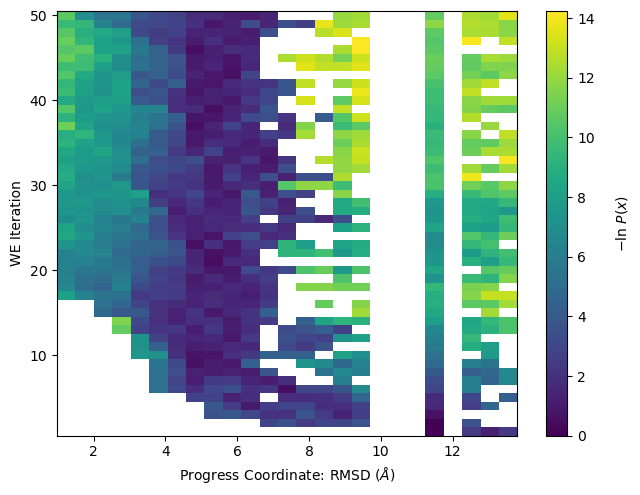

In [2]:
wedap.H5_Plot(h5="completed_files/west.h5", data_type="evolution", Xname="pcoord", bins=25).plot()
plt.ylabel("WE Iteration")
plt.xlabel("Progress Coordinate: RMSD ($\AA$)")

Alternatively we could use the GUI or command line:
```bash
$ wedap -h5 completed_files/west.h5 -X pcoord
```

Here, we can see that the RMSD to the folded NTL9 structure initially starts at around 11 Å in the first few iterations, which then evolves over the course of the WE simlation to eventually reach a <2 Å folded state around WE iteration 25.

### Joint Plots

We can also look at average probability distributions over a range of WE iterations. In this example, we use just the RMSD or both RMSD and SASA. We create a joint plot (by setting `jointplot=True`) with the 2D probability distribution in the main panel and 1D probability distributions in the margins. We use the matplotlib object oriented interface to then label the axes.

Average 2D:   0%|          | 0/50 [00:00<?, ?it/s]

Text(29.222222222222214, 0.5, 'SASA ($\\AA^2$)')

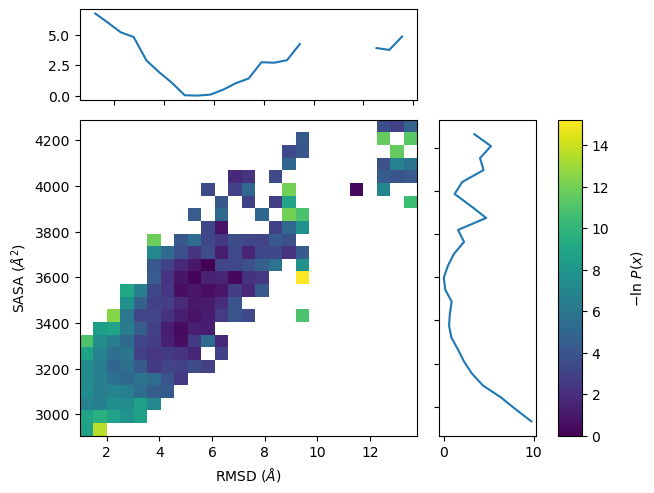

In [3]:
jp = wedap.H5_Plot(h5="completed_files/west.h5", data_type="average", Xname="rmsd", Yname="sasa", bins=25, jointplot=True)
jp.plot()
jp.ax.set_xlabel("RMSD ($\AA$)")
jp.ax.set_ylabel("SASA ($\AA^2$)")

Alternatively we could use the command line:
```bash
$ wedap -h5 completed_files/west.h5 -X rmsd -Y sasa -jp
```

We can see that overall, the RMSD and SASA have a linear relationship, where as NTL9 folds and decreases in RMSD to the folded state, the SASA also (logically) decreases. We also can see more stable intermediates on the 1D SASA marginal distribution.

### Tracing a trajectory

What if we wanted to trace and plot a single pathway to the target state? During the `westpa.analysis` tutorial, you'll go through how to look at successful events and traced paths in more depth, and then you could use those iteration and segment values to plot a trace with this additional command line argument:
```Bash
--trace-seg ITER SEG
```
For this tutorial, we can find a trajectory that is near a specific RMSD and SASA value with the following command line argument:
```Bash
--trace-val RMSD SASA
```
Or using the following Python code:

Average 2D:   0%|          | 0/50 [00:00<?, ?it/s]

Trace Search:   0%|          | 0/50 [00:00<?, ?it/s]

Tracing ITERATION: 33, SEGMENT: 0


Text(29.222222222222214, 0.5, 'SASA ($\\AA^2$)')

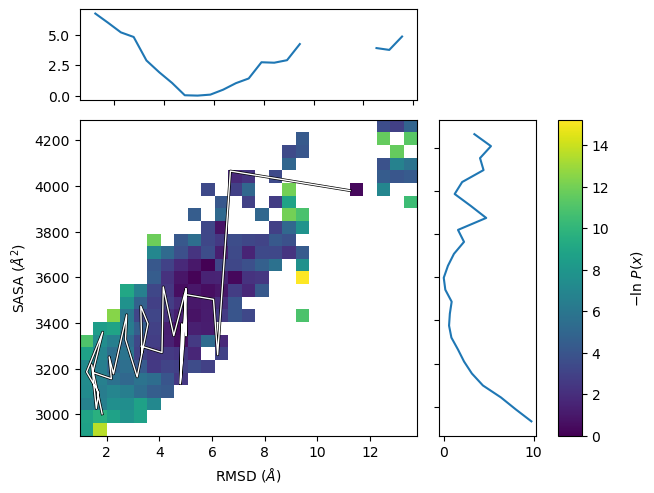

In [4]:
# instantiate the plotting class and run main plot method
jp = wedap.H5_Plot(h5="completed_files/west.h5", data_type="average", Xname="rmsd", Yname="sasa", bins=25, jointplot=True)
jp.plot()
# include this line to trace a trajectory nearest to a RMSD value of 1.5 and a SASA value of 3000
jp.plot_trace((1.5, 3000), ax=jp.ax, find_iter_seg=True)
# plot formatting
jp.ax.set_xlabel("RMSD ($\AA$)")
jp.ax.set_ylabel("SASA ($\AA^2$)")

Alternatively we could use the command line:
```bash
$ wedap -h5 completed_files/west.h5 -X rmsd -Y sasa -jp --trace-val 1.5 3000
```
Note again that the probability distributions and the traced trajectories might look odd they are much more discrete in our example since we are using SynD.

### GIF

Next, let's take it a step further and generate an animated GIF of the 2D probability evolution over time:

Here we build a `plot_options` dictionary with various plot settings. This gets passed into the `make_gif` function along with: `avg_plus` which determines the amount of WE iterations to include in each frame, `gif_out` which is the output name/path for the gif, and `duration` which sets the amount of time between each frame (in ms).

In [5]:
plot_options = {"h5" : "completed_files/west.h5",
                "Xname" : "rmsd",
                "Yname" : "sasa",
                "data_type" : "average",
                "p_max" : 15,
                "first_iter" : 1,
                "last_iter" : 50,
                "plot_mode" : "hist",
                "xlabel" : "RMSD ($\AA$)",
                "ylabel" : "SASA ($\AA^2$)",
                "xlim" : (0, 15),
                "ylim" : (2900, 4400),
                "grid" : True,
                "cmap" : "gnuplot_r",
                "bins" : 50,
                }
wedap.make_gif(**plot_options, avg_plus=1, gif_out="example.gif", duration=100)

  0%|          | 0/49 [00:00<?, ?it/s]

We just created a gif named `example.gif`. Let's see what it looks like:

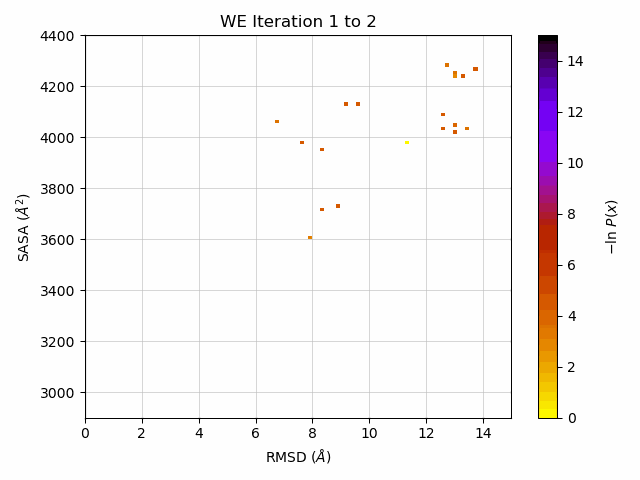

In [6]:
from IPython.display import Image
Image(open('example.gif','rb').read())

This kind of visual let's us track the probability changes over time along with the recycling events!

Alternatively we could use the command line:
```bash
$ wedap -h5 completed_files/west.h5 -X rmsd -Y sasa --pmax 15 --xlim 0 15 --ylim 2900 4400 --grid --cmap gnuplot_r --avg-plus 1 --gif-out example.gif --duration 100
```